In [1]:
#Libraries imports
import torch
import edward
from edward.models import Categorical, Mixture, Normal
import pandas as pd
from sklearn.metrics import mean_squared_error
import time
import numpy as np
import random
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
#Load test data and necessary data for prediction inspection

with open('/tmp/PredictionPDF.pt','rb') as f:
         probs = torch.load(f)
with open('/tmp/PDFCenters.pt','rb') as f:
         centers = torch.load(f)
with open('tst_data.pt','rb') as f:
      test_ = torch.load(f)


#Load N test points
N = 10
test_data = test_[random.sample(range(0, len(test_)), N),:] 

In [14]:
#Inspect posterior predictive distribution

y_post = []
sigma_y = 1.0
n_samples = 100

t0 = time.time()
for i in range(len(test_data)):
    print("Forming the posterior predictive distribution for test data point", i+1, "/", len(test_data), "...")
    y_post.append(Mixture(Categorical(probs = probs[i]), 
                  [Normal(loc=centers[i][j], scale=sigma_y) for j in range(len(centers[i]))]))
    
print("Took altogether", np.int(time.time() - t0), "secs.")

t0 = time.time()
print("Sampling the posterior predictive distribution for", len(test_data), "test data points...")
posteriorsamplenodes = tf.stack([y_post[i].sample(n_samples) for i in range(len(test_data))], axis=1)
with tf.Session().as_default():
     posteriorsamples = pd.DataFrame(posteriorsamplenodes.eval())


print("Took", np.int(time.time() - t0), "secs.")

('Forming the posterior predictive distribution for test data point', 1, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 2, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 3, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 4, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 5, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 6, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 7, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 8, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 9, '/', 10, '...')
('Forming the posterior predictive distribution for test data point', 10, '/', 10, '...')
('Took altogether', 9, 'secs.')
('Sampling the posterior predictive distribution for', 10, 'test data points.

In [16]:
#Inspect prediction statistics

predictions = posteriorsamples.mean()
predictions_low = posteriorsamples.quantile(0.01)
predictions_high = posteriorsamples.quantile(0.99)

results = pd.DataFrame()
results['Bayesian_prediction'] = predictions
print(predictions)
results['Bayesian_prediction_low'] = predictions_low
results['Bayesian_prediction_high'] = predictions_high

print("MSE on test data for Bayesian neural network:")
print(np.round(mean_squared_error(results['Bayesian_prediction'], test_data[:,2]), 2))
results = results.applymap(lambda x: np.round(x,2))
results

0    0.800755
1    0.779542
2    0.465991
3    0.804469
4    0.575531
5    0.473947
6    0.547738
7    0.620398
8    0.501135
9    0.611454
dtype: float32
MSE on test data for Bayesian neural network:
0.26


,Bayesian_prediction,Bayesian_prediction_low,Bayesian_prediction_high
0,0.80,-1.29,2.91
1,0.78,-1.25,2.90
2,0.47,-1.88,2.78
3,0.80,-1.39,3.61
4,0.58,-1.46,3.91
5,0.47,-2.20,3.06
6,0.55,-2.07,2.62
7,0.62,-2.06,3.22
8,0.50,-2.12,3.16
9,0.61,-1.87,3.08


2


Text(0.5,1,'Results for test data point 2')

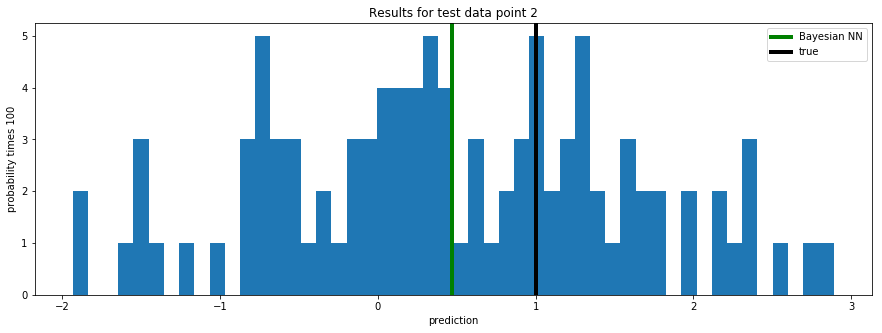

In [17]:
#Visualise one (random) prediction and associated uncertainty

test_sample_number = np.random.choice(range(len(test_data)))
print(test_sample_number)

3    0.698106
plt.figure(figsize=(15,5))

_, _, histogram = plt.hist(posteriorsamples[test_sample_number].values, bins=50)
plt.xlabel("prediction")
plt.ylabel("probability times " + str(n_samples))
plt.axvline(results.loc[test_sample_number, 'Bayesian_prediction'], color='g', linewidth=4, label="Bayesian NN")
plt.axvline(test_data[test_sample_number,2], color='k', linewidth=4, label="true")
plt.legend()
plt.title("Results for test data point " + str(test_sample_number))